# Big Data Analytics Project: Amazon Review Sentiment Analysis with SparkML

This notebook implements a complete Big Data pipeline using PySpark on Google Colab. It processes the Amazon Reviews 2023 dataset (Beauty subset) with item metadata to predict sentiment and extract insights.

**Enhanced Project Overview:**
1.  **Setup**: Install Spark, spaCy, and mount Drive for persistence.
2.  **ETL**: Load reviews AND item metadata from Hugging Face, convert to Parquet.
3.  **Preprocessing**: Join datasets, combine review title+body, clean text, add custom stop words.
4.  **Feature Engineering**: Tokenization → Lemmatization → N-grams (bigrams) → CountVectorizer → TF-IDF.
5.  **Modeling**: Train 3 models - Logistic Regression, Random Forest, and Naive Bayes.
6.  **Evaluation**: Comprehensive metrics (AUC-ROC, AUC-PR, F1, Precision, Recall) with comparison charts.
7.  **Explainability**: Feature importance analysis with top positive/negative words.
8.  **Error Analysis**: Misclassification analysis, confidence analysis, error word clouds.
9.  **Insights**: Sentiment Distribution, Word Clouds, and LDA Topic Modeling.
10. **Reporting**: Save models, predictions, and comparison results.

In [2]:
# 1. Environment Setup
# Install necessary libraries for Spark and Hugging Face Datasets
import warnings
warnings.filterwarnings('ignore', message='.*pip.*dependency.*')

print("Installing required packages...")
!pip install -q pyspark==3.5.1 delta-spark "datasets<3.0.0" "fsspec==2024.6.1" wordcloud matplotlib seaborn scikit-learn --quiet 2>/dev/null
print("PySpark, datasets, wordcloud, and visualization libraries installed")

from google.colab import drive
import os

drive.mount('/content/drive')

# Define project paths
PROJECT_DIR = "/content/drive/MyDrive/BDA_Project"
DATA_DIR = os.path.join(PROJECT_DIR, "data")
MODEL_DIR = os.path.join(PROJECT_DIR, "models")
OUTPUT_DIR = os.path.join(PROJECT_DIR, "output")

# Create directories if they don't exist
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Project directories created at {PROJECT_DIR}")

Installing required packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.6/177.6 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 41.2 MB/s eta 0:00:00
PySpark, datasets, wordcloud, and visualization libraries installed
Mounted at /content/drive
Project directories created at /content/drive/MyDrive/BDA_Project


In [3]:
# Install spaCy for lemmatization (Colab)
!pip install -q spacy
!python -m spacy download en_core_web_sm

print('spaCy installed and model downloaded')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 111.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
spaCy installed and model downloaded


In [4]:
# 2. Data Loading and Batch Conversion to Parquet
from datasets import load_dataset
import pyarrow.parquet as pq
import pyarrow as pa

# Configuration
DATASET_NAME = "McAuley-Lab/Amazon-Reviews-2023"
REVIEW_CONFIG = "raw_review_All_Beauty"
META_CONFIG = "raw_meta_All_Beauty"  # Item metadata
SPLIT = "full[:10%]"
BATCH_SIZE = 10000
PARQUET_FILE = os.path.join(DATA_DIR, "reviews.parquet")
META_PARQUET_FILE = os.path.join(DATA_DIR, "metadata.parquet")

# Helper function to save dataset to Parquet in batches
def save_to_parquet_batched(dataset, output_path, batch_size=10000):
    if os.path.exists(output_path):
        print(f"File {output_path} already exists. Skipping write.")
        return
    print(f"Writing to {output_path}...")
    schema = dataset.features.arrow_schema
    with pq.ParquetWriter(output_path, schema) as writer:
        for i in range(0, len(dataset), batch_size):
            batch = dataset.select(range(i, min(i + batch_size, len(dataset))))
            table = pa.Table.from_batches(batch.data.to_batches())
            writer.write_table(table)
    print("Write complete.")

# Load and save REVIEWS
print(f"Loading {SPLIT} of {DATASET_NAME} (reviews)...")
ds_reviews = load_dataset(DATASET_NAME, REVIEW_CONFIG, split=SPLIT, trust_remote_code=True)
print(f"Reviews loaded. Rows: {len(ds_reviews)}")
save_to_parquet_batched(ds_reviews, PARQUET_FILE, BATCH_SIZE)

# Load and save METADATA (full metadata, we'll filter in Spark)
print(f"\nLoading {DATASET_NAME} (item metadata)...")
ds_meta = load_dataset(DATASET_NAME, META_CONFIG, split="full", trust_remote_code=True)
print(f"Metadata loaded. Rows: {len(ds_meta)}")
save_to_parquet_batched(ds_meta, META_PARQUET_FILE, BATCH_SIZE)

print("\nBoth datasets saved to Parquet.")

Loading full[:10%] of McAuley-Lab/Amazon-Reviews-2023 (reviews)...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating full split: 0 examples [00:00, ? examples/s]

Reviews loaded. Rows: 70153
File /content/drive/MyDrive/BDA_Project/data/reviews.parquet already exists. Skipping write.

Loading McAuley-Lab/Amazon-Reviews-2023 (item metadata)...


Generating full split:   0%|          | 0/112590 [00:00<?, ? examples/s]

Metadata loaded. Rows: 112590
File /content/drive/MyDrive/BDA_Project/data/metadata.parquet already exists. Skipping write.

Both datasets saved to Parquet.


In [7]:
# 3. Initialize Spark Session
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("AmazonReviewSentiment") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.parquet.compression.codec", "snappy") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")
print("Spark Session Created")
print(spark)

def keep_runtime_alive():
    import time
    import IPython.display as display

    # Keep runtime alive by outputting every 5 minutes
    start_time = time.time()
    while time.time() - start_time < 600:
        elapsed = int(time.time() - start_time)
        display.clear_output(wait=True)
        print(f"✓ Runtime keep-alive: {elapsed}s elapsed")
        time.sleep(300)

Spark Session Created


In [8]:
# 4. Load Data into Spark & Preprocessing (Enhanced with Metadata Join)
from pyspark.sql.functions import col, when, length, trim, concat_ws, coalesce, lit, regexp_replace, lower
from pyspark.sql.types import DoubleType, IntegerType, StringType

# Read Reviews Parquet
df = spark.read.parquet(PARQUET_FILE)
df.cache()
print("Reviews Schema:")
df.printSchema()
print(f"Review Columns: {df.columns}")

# Read Metadata Parquet
meta_df = spark.read.parquet(META_PARQUET_FILE)
print("\nMetadata Schema:")
meta_df.printSchema()
print(f"Metadata Columns: {meta_df.columns}")

# Select relevant metadata columns (TEXT ONLY - no images/videos)
meta_select = meta_df.select(
    col("parent_asin"),
    col("main_category"),
    col("store").alias("brand"),
    col("price").cast(DoubleType()).alias("product_price"),
    col("average_rating").alias("product_avg_rating"),
    col("rating_number").alias("product_rating_count")
).dropDuplicates(["parent_asin"])

print(f"Metadata rows (deduplicated): {meta_select.count()}")

# Join reviews with metadata on parent_asin
df_joined = df.join(meta_select, on="parent_asin", how="left")
print(f"Joined dataset rows: {df_joined.count()}")

# Determine timestamp column
timestamp_col = None
if "timestamp" in df_joined.columns:
    timestamp_col = (col("timestamp") / 1000).cast("timestamp")
elif "unixReviewTime" in df_joined.columns:
    timestamp_col = col("unixReviewTime").cast("timestamp")

# Build selection with Enhanced text (title + text combined)
select_cols = [
    col("parent_asin"),
    col("title").alias("review_title"),  # Review title
    col("text").alias("review_body"),    # Review body
    col("rating").cast(DoubleType()).alias("rating"),
    col("main_category"),
    col("brand"),
    col("product_price"),
    col("verified_purchase"),
    col("helpful_vote")
]
if timestamp_col is not None:
    select_cols.append(timestamp_col.alias("review_date"))

# Create combined review text (title + body) and clean
clean_df = df_joined.select(*select_cols).filter(
    (col("review_body").isNotNull()) &
    (length(trim(col("review_body"))) > 10)
).withColumn(
    # Combine review title and body for richer text
    "review_text",
    concat_ws(" ", coalesce(col("review_title"), lit("")), col("review_body"))
).withColumn(
    # Clean text: remove HTML tags, URLs, extra whitespace
    "review_text",
    regexp_replace(col("review_text"), r"<[^>]+>", " ")  # Remove HTML
).withColumn(
    "review_text",
    regexp_replace(col("review_text"), r"https?://\S+", " ")  # Remove URLs
).withColumn(
    "review_text",
    regexp_replace(col("review_text"), r"\s+", " ")  # Normalize whitespace
).withColumn(
    "review_text",
    trim(lower(col("review_text")))  # Lowercase and trim
).dropDuplicates(["review_text"]).withColumn(
    "label", when(col("rating") >= 4.0, 1.0).otherwise(0.0)
)

print(f"\nCleaned Data Count: {clean_df.count()}")
clean_df.select("review_text", "rating", "label", "main_category", "brand").show(5, truncate=60)

# Check class distribution
print("\nClass Distribution:")
clean_df.groupBy("label").count().show()

# Train/Test Split
train_df, test_df = clean_df.randomSplit([0.8, 0.2], seed=42)
print(f"Train rows: {train_df.count()}, Test rows: {test_df.count()}")

label_counts = {row["label"]: row["count"] for row in train_df.groupBy("label").count().collect()}
pos_count = float(label_counts.get(1.0, 1))
neg_count = float(label_counts.get(0.0, 1))
total_count = pos_count + neg_count
# Balanced weights: w_c = total / (2 * count_c)
pos_weight = total_count / (2.0 * pos_count)
neg_weight = total_count / (2.0 * neg_count)
print(f"Class weights -> positive: {pos_weight:.3f}, negative: {neg_weight:.3f}")

train_df_w = train_df.withColumn("class_weight", when(col("label") == 1.0, pos_weight).otherwise(neg_weight))
test_df_w = test_df.withColumn("class_weight", when(col("label") == 1.0, pos_weight).otherwise(neg_weight))

Reviews Schema:
root
 |-- rating: double (nullable = true)
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- images: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- attachment_type: string (nullable = true)
 |    |    |-- large_image_url: string (nullable = true)
 |    |    |-- medium_image_url: string (nullable = true)
 |    |    |-- small_image_url: string (nullable = true)
 |-- asin: string (nullable = true)
 |-- parent_asin: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- timestamp: long (nullable = true)
 |-- helpful_vote: long (nullable = true)
 |-- verified_purchase: boolean (nullable = true)

Review Columns: ['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id', 'timestamp', 'helpful_vote', 'verified_purchase']

Metadata Schema:
root
 |-- main_category: string (nullable = true)
 |-- title: string (nullable = true)
 |-- average_rating: double (nullable = true)
 |-- rating_num

In [9]:
# If runtime disconnected during training, this loads saved models
import os
from pyspark.ml import PipelineModel

# Check if models were previously saved
lr_model_exists = os.path.exists(os.path.join(MODEL_DIR, "sentiment_spark_lr_model"))
rf_model_exists = os.path.exists(os.path.join(MODEL_DIR, "sentiment_spark_rf_model"))
nb_model_exists = os.path.exists(os.path.join(MODEL_DIR, "sentiment_spark_nb_model"))

if lr_model_exists or rf_model_exists or nb_model_exists:
    print("Found previously trained models! Loading them...")

    if lr_model_exists:
        best_model = PipelineModel.load(os.path.join(MODEL_DIR, "sentiment_spark_lr_model"))
        print("Logistic Regression model loaded")

    if rf_model_exists:
        best_rf_model = PipelineModel.load(os.path.join(MODEL_DIR, "sentiment_spark_rf_model"))
        print("Random Forest model loaded")

    if nb_model_exists:
        best_nb_model = PipelineModel.load(os.path.join(MODEL_DIR, "sentiment_spark_nb_model"))
        print("Naive Bayes model loaded")

    print("\nYou can skip the training cells below and jump to model evaluation (Cell 6).")
    print("Or re-run training cells to retrain models from scratch.\n")
else:
    print("No previous checkpoints found. Ready for fresh training.\n")

Found previously trained models! Loading them...
Logistic Regression model loaded
Random Forest model loaded
Naive Bayes model loaded

You can skip the training cells below and jump to model evaluation (Cell 6).
Or re-run training cells to retrain models from scratch.



# 4b. Advanced Data Exploration
In this section, we'll dive deeper into the dataset to uncover more subtle patterns. We will analyze:
1.  **Review Length**: Is there a connection between the length of a review and its sentiment?
2.  **Time-Based Trends**: How has sentiment evolved over time?
3.  **Category Analysis**: How does sentiment vary across different product categories?


Review length descriptive statistics (Spark):
+-------+------------------+
|summary|     review_length|
+-------+------------------+
|  count|             66516|
|   mean| 242.3490588730531|
| stddev|309.90414338697934|
|    min|                13|
|    max|              9746|
+-------+------------------+

25th/50th/75th percentiles: [72.0, 149.0, 280.0]
   label     avg_len  median_len label_str
0    0.0  237.517939         158  Negative
1    1.0  244.100621         145  Positive


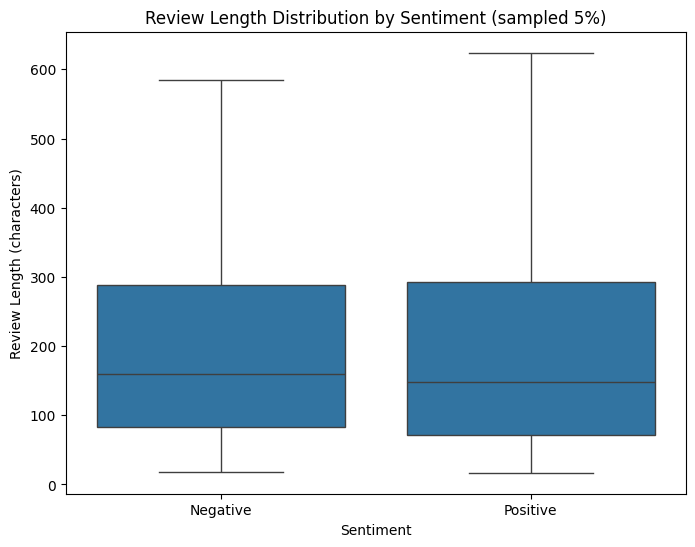

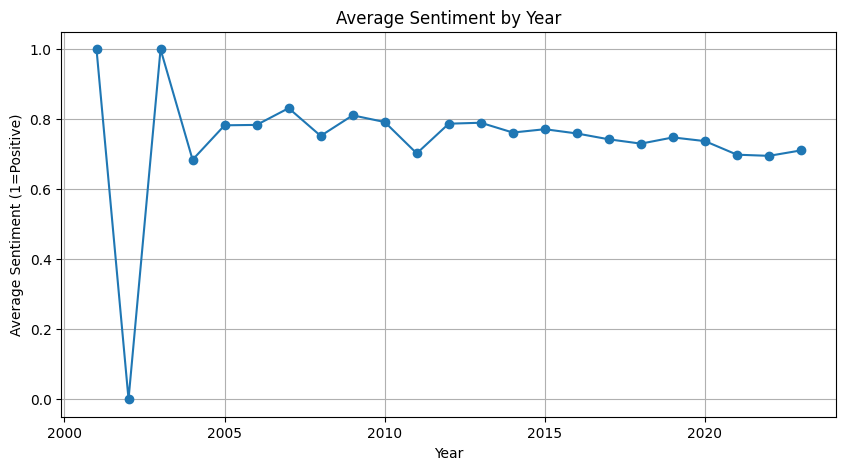

Found category-like columns: ['parent_asin']


/tmp/ipython-input-2071775350.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_sentiment', y='category', data=cat_sentiment, palette='coolwarm')


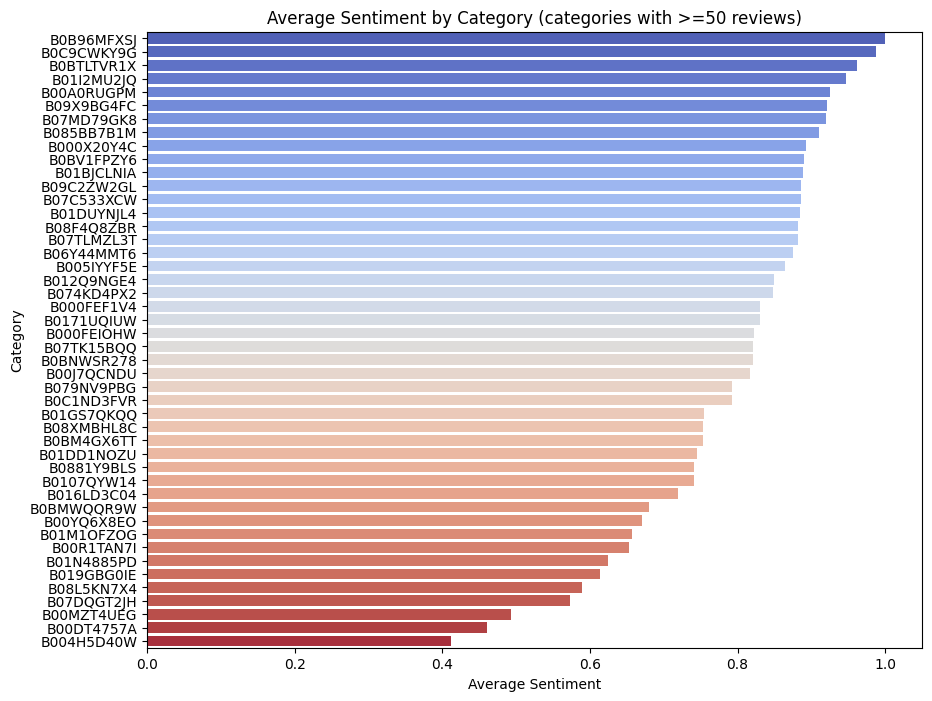

In [10]:
from pyspark.sql.functions import length, date_format, avg, year, col as Fcol, percentile_approx, when, count
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Add review length column
review_length_df = clean_df.withColumn("review_length", length(Fcol("review_text")))

# Descriptive statistics for review length
print("Review length descriptive statistics (Spark):")
review_length_df.select("review_length").describe().show()

# Median and quartiles using approxQuantile
quantiles = review_length_df.approxQuantile("review_length", [0.25, 0.5, 0.75], 0.01)
print(f"25th/50th/75th percentiles: {quantiles}")

# Average/median review length by sentiment label
agg_by_label = review_length_df.groupBy("label").agg(
    avg("review_length").alias("avg_len"),
    percentile_approx("review_length", 0.5).alias("median_len")
).orderBy("label").toPandas()
agg_by_label['label_str'] = agg_by_label['label'].map({1.0: 'Positive', 0.0: 'Negative'})
print(agg_by_label)

# Boxplot (sample for plotting to keep memory usage reasonable)
sample_pd = review_length_df.select("label", "review_length").sample(False, 0.05, seed=42).toPandas()
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='review_length', data=sample_pd, showfliers=False)
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.title('Review Length Distribution by Sentiment (sampled 5%)')
plt.xlabel('Sentiment')
plt.ylabel('Review Length (characters)')
plt.show()

# Time-Based Trends: extract year and compute average sentiment per year
if 'review_date' in review_length_df.columns:
    by_year = review_length_df.withColumn('year', year(Fcol('review_date')))
    year_sentiment = by_year.groupBy('year').agg(avg('label').alias('avg_sentiment')).orderBy('year').toPandas()

    plt.figure(figsize=(10, 5))
    plt.plot(year_sentiment['year'].astype(int), year_sentiment['avg_sentiment'], marker='o')
    plt.title('Average Sentiment by Year')
    plt.xlabel('Year')
    plt.ylabel('Average Sentiment (1=Positive)')
    plt.grid(True)
    plt.show()
else:
    print("No 'review_date' column available for time-based trends. If you have a timestamp column (unixReviewTime), rerun preprocessing to create 'review_date'.")

# Category Analysis placeholder: check for common category columns
possible_category_cols = [c for c in df.columns if 'category' in c.lower() or 'product_category' in c.lower() or 'parent' in c.lower()]
if possible_category_cols:
    print('Found category-like columns:', possible_category_cols)
    # Use the first candidate
    cat_col = possible_category_cols[0]
    cat_sentiment = df.select(Fcol(cat_col).alias('category'), Fcol('text').alias('review_text'), Fcol('rating')) \
        .withColumn('label', when(Fcol('rating') >= 4.0, 1.0).otherwise(0.0)) \
        .groupBy('category').agg(avg('label').alias('avg_sentiment'), count('*').alias('count')) \
        .orderBy('avg_sentiment', ascending=False).toPandas()
    cat_sentiment = cat_sentiment[cat_sentiment['count'] >= 50]  # filter rare categories
    plt.figure(figsize=(10, 8))
    sns.barplot(x='avg_sentiment', y='category', data=cat_sentiment, palette='coolwarm')
    plt.title('Average Sentiment by Category (categories with >=50 reviews)')
    plt.xlabel('Average Sentiment')
    plt.ylabel('Category')
    plt.show()
else:
    print('No category column detected; skipping category-level analysis.')

In [11]:
# Lemmatization Transformer (uses spaCy)
from pyspark.ml import Transformer
from pyspark.sql.types import ArrayType, StringType, IntegerType
from pyspark.sql.functions import udf

class LemmatizerTransformer(Transformer):
    def __init__(self, inputCol='words', outputCol='lemmatized_words'):
        super(LemmatizerTransformer, self).__init__()
        self.inputCol = inputCol
        self.outputCol = outputCol

    def _transform(self, dataset):
        def _lemmatize(tokens):
            # Lazy-load spaCy model per worker
            try:
                nlp = _lemmatize._nlp
            except AttributeError:
                import spacy
                _lemmatize._nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
                nlp = _lemmatize._nlp
            if not tokens:
                return []
            # spaCy expects a string; join tokens while preserving spaces
            doc = nlp(' '.join(tokens))
            lemmas = [tok.lemma_.lower() for tok in doc if tok.lemma_.strip()]
            return lemmas

        lemmatize_udf = udf(_lemmatize, ArrayType(StringType()))
        return dataset.withColumn(self.outputCol, lemmatize_udf(dataset[self.inputCol]))

print('LemmatizerTransformer defined')

LemmatizerTransformer defined


In [ ]:
# 5. Build SparkML Pipeline (ENHANCED TUNING for Better Accuracy)
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF, NGram
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import time
import sys

print("Setting up Logistic Regression pipeline...")
default_stop_words = StopWordsRemover.loadDefaultStopWords("english")
custom_stop_words = [
    "product", "item", "amazon", "ordered", "received", "buy", "bought",
    "purchase", "purchased", "one", "two", "three", "get", "got", "use",
    "used", "using", "would", "could", "really", "just", "like", "also",
    "even", "much", "very", "well", "good", "great", "nice", "love", "loved"
]
all_stop_words = list(set(default_stop_words + custom_stop_words))
print(f"Stop words configured ({len(all_stop_words)} words)")

# === PIPELINE STAGES ===
print("Building pipeline stages...")

# 1. Tokenize: Convert text to words
print("   1. Tokenizer...", end="", flush=True)
tokenizer = RegexTokenizer(inputCol="review_text", outputCol="words", pattern="\\W", minTokenLength=2)
print(" ✓")

# 2. Remove Stop Words (with custom domain words)
print("   2. Stop Words Remover...", end="", flush=True)
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words", stopWords=all_stop_words)
print(" ✓")

# 3. Bigrams (captures phrases like "not good", "highly recommend")
print("   3. Bigram extractor...", end="", flush=True)
bigram = NGram(n=2, inputCol="filtered_words", outputCol="bigrams")
print(" ✓")

# 4. CountVectorizer for Unigrams
print("   4. CountVectorizer (unigrams: 2000)...", end="", flush=True)
cv_unigram = CountVectorizer(inputCol="filtered_words", outputCol="unigram_features",
                              vocabSize=2000, minDF=3.0)
print(" ✓")

# 5. CountVectorizer for Bigrams
print("   5. CountVectorizer (bigrams: 1000)...", end="", flush=True)
cv_bigram = CountVectorizer(inputCol="bigrams", outputCol="bigram_features",
                             vocabSize=1000, minDF=2.0)
print(" ✓")

# 6. Combine features using VectorAssembler
print("   6. Feature assembler...", end="", flush=True)
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=["unigram_features", "bigram_features"], outputCol="combined_features")
print(" ✓")

# 7. IDF weighting
print("   7. TF-IDF transformer...", end="", flush=True)
idf = IDF(inputCol="combined_features", outputCol="features")
print(" ✓")

# 8. Logistic Regression Classifier (ENHANCED: Increased iterations for better convergence + class weights)
print("   8. Logistic Regression (maxIter=10, class weights) ...", end="", flush=True)
lr = LogisticRegression(featuresCol="features", labelCol="label", weightCol="class_weight", maxIter=10)
print(" ✓")

print("\nAssembling complete pipeline...")
pipeline = Pipeline(stages=[
    tokenizer, remover, bigram,
    cv_unigram, cv_bigram, assembler, idf, lr
])
print("8 pipeline stages assembled")

print("\nHyperparameter Grid (12 combinations):")
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.05, 0.1, 0.3]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5]) \
    .build()
print("   regParam: [0.01, 0.05, 0.1, 0.3]")
print("   elasticNetParam: [0.0 (L2), 0.25, 0.5 (L1+L2)]")
print("   Total combinations: 12")
print("   Expected training time: ~10-12 minutes")

# Evaluator
print("\nSetting up evaluation metric...")
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
print("   Evaluator: Area Under ROC Curve")

# TrainValidationSplit (faster than CrossValidator)
print("\nTrain-Validation Split configuration:")
tvs = TrainValidationSplit(estimator=pipeline,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.8,
                           parallelism=2)
print("   Train ratio: 80%")
print("   Validation ratio: 20%")
print("   Parallelism: 2 (concurrent evaluations)")

import shutil
from datetime import datetime

checkpoint_file = os.path.join(MODEL_DIR, "lr_training_checkpoint.txt")

try:
    start_time = time.time()
    print(f"\nTraining started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("Fitting pipeline with 12 hyperparameter combinations...")
    print("This may take ~10-12 minutes...\n")

    # Flush output to ensure it appears in Colab
    sys.stdout.flush()

    model = tvs.fit(train_df_w)

    training_time = time.time() - start_time

    # Save checkpoint immediately after training
    with open(checkpoint_file, "w") as f:
        f.write(f"LR Training completed successfully at {datetime.now()}\n")
        f.write(f"Training time: {training_time:.1f} seconds\n")

    print(f" Training time: {training_time:.1f} seconds ({training_time/60:.1f} minutes)")
    print(f" Checkpoint saved at {datetime.now().strftime('%H:%M:%S')}")

except Exception as e:
    print(f"TRAINING FAILED")
    print(f"Error: {str(e)}")
    print("If runtime disconnected, re-run this cell to resume training")
    raise

# Extract best model
best_model = model.bestModel

print("\nSaving model to Google Drive...")
lr_model_path = os.path.join(MODEL_DIR, "sentiment_spark_lr_model")
if os.path.exists(lr_model_path):
    print("   Overwriting existing model...")
    shutil.rmtree(lr_model_path)

best_model.save(lr_model_path)
print(f"Model saved successfully!")
print(f"Location: {lr_model_path}\n")

print("Best Hyperparameters (from 12 combinations tested):")
print(f"  • Regularization (regParam): {best_model.stages[-1].getRegParam()}")
print(f"  • ElasticNet Mix (0=L2, 1=L1): {best_model.stages[-1].getElasticNetParam()}")
print(f"  • Max Iterations: 10")
print(f"  • Unigram Vocab Size: {len(best_model.stages[3].vocabulary)}")
print(f"  • Bigram Vocab Size: {len(best_model.stages[4].vocabulary)}")

Setting up Logistic Regression pipeline...
Stop words configured (209 words)
Building pipeline stages...
   1. Tokenizer... ✓
   2. Stop Words Remover... ✓
   3. Bigram extractor... ✓
   4. CountVectorizer (unigrams: 2000)... ✓
   5. CountVectorizer (bigrams: 1000)... ✓
   6. Feature assembler... ✓
   7. TF-IDF transformer... ✓
   8. Logistic Regression (maxIter=10, class weights) ... ✓

Assembling complete pipeline...
8 pipeline stages assembled

Hyperparameter Grid (12 combinations):
   regParam: [0.01, 0.05, 0.1, 0.3]
   elasticNetParam: [0.0 (L2), 0.25, 0.5 (L1+L2)]
   Total combinations: 12
   Expected training time: ~10-12 minutes

Setting up evaluation metric...
   Evaluator: Area Under ROC Curve

Train-Validation Split configuration:
   Train ratio: 80%
   Validation ratio: 20%
   Parallelism: 2 (concurrent evaluations)

Training started at 2025-12-06 17:33:17
Fitting pipeline with 12 hyperparameter combinations...
This may take ~10-12 minutes...



In [10]:
# 5b. Build Alternative Model: Random Forest Classifier (ENHANCED TUNING)
from pyspark.ml.classification import RandomForestClassifier
import time
import shutil
from datetime import datetime
import sys

# RF Classifier
print("\nConfiguring Random Forest...")
rf = RandomForestClassifier(featuresCol="features", labelCol="label", seed=42)

# RF Pipeline: reuse preprocessing stages from LR pipeline
print("\nBuilding Random Forest pipeline...")
rf_pipeline = Pipeline(stages=[
    tokenizer, remover, bigram,
    cv_unigram, cv_bigram, assembler, idf, rf
])
print("    8 pipeline stages (reusing tokenizer, vectorizer, etc.)")

print("\nHyperparameter Grid (Testing 6 combinations):")
rf_paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [30, 50, 70]) \
    .addGrid(rf.maxDepth, [6, 10]) \
    .build()
print("    numTrees: [30, 50, 70]")
print("    maxDepth: [6, 10]")
print("    Total combinations: 6")
print("     Expected training time: 10-13 minutes")

print("\nTrain-Validation Split configuration:")
rf_tvs = TrainValidationSplit(estimator=rf_pipeline,
                              estimatorParamMaps=rf_paramGrid,
                              evaluator=evaluator,
                              trainRatio=0.8,
                              parallelism=2)
print("    Train ratio: 80%")
print("    Validation ratio: 20%")
print("    Parallelism: 2 (concurrent evaluations)")

checkpoint_file = os.path.join(MODEL_DIR, "rf_training_checkpoint.txt")

try:
    start_time = time.time()
    print(f"\n  Training started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("    Fitting pipeline with 6 hyperparameter combinations...")
    print("    This may take 5-8 minutes (Random Forest + enhanced tuning)...\n")

    # Flush output to ensure it appears in Colab
    sys.stdout.flush()

    rf_model_tvs = rf_tvs.fit(train_df)

    training_time = time.time() - start_time

    # Save checkpoint immediately
    with open(checkpoint_file, "w") as f:
        f.write(f"RF Training completed successfully at {datetime.now()}\n")
        f.write(f"Training time: {training_time:.1f} seconds\n")

    print(f"  Training time: {training_time:.1f} seconds ({training_time/60:.1f} minutes)")
    print(f" Checkpoint saved at {datetime.now().strftime('%H:%M:%S')}")

except Exception as e:
    print("\n" + "="*80)
    print(f"TRAINING FAILED")
    print("="*80)
    print(f"Error: {str(e)}")
    print("If runtime disconnected, re-run this cell to resume training")
    raise

best_rf_model = rf_model_tvs.bestModel

print("\n Saving model to Google Drive...")
rf_model_path = os.path.join(MODEL_DIR, "sentiment_spark_rf_model")
if os.path.exists(rf_model_path):
    print("  Overwriting existing model...")
    shutil.rmtree(rf_model_path)

best_rf_model.save(rf_model_path)
print(f" Model saved successfully!")
print(f"  Location: {rf_model_path}\n")

print(" Best RF Hyperparameters (from 6 combinations tested):")
print(f"  • Number of Trees: {best_rf_model.stages[-1].getNumTrees}")
print(f"  • Max Depth: {best_rf_model.stages[-1].getMaxDepth()}")
print(f"  • Feature Subset Strategy: {best_rf_model.stages[-1].getFeatureSubsetStrategy()}")


Configuring Random Forest...

Building Random Forest pipeline...
    8 pipeline stages (reusing tokenizer, vectorizer, etc.)

Hyperparameter Grid (Testing 6 combinations):
    numTrees: [30, 50, 70]
    maxDepth: [6, 10]
    Total combinations: 6
     Expected training time: 10-13 minutes

Train-Validation Split configuration:
    Train ratio: 80%
    Validation ratio: 20%
    Parallelism: 2 (concurrent evaluations)

  Training started at 2025-12-06 17:13:49
    Fitting pipeline with 6 hyperparameter combinations...
    This may take 5-8 minutes (Random Forest + enhanced tuning)...

  Training time: 406.2 seconds (6.8 minutes)
 Checkpoint saved at 17:20:35

 Saving model to Google Drive...
 Model saved successfully!
  Location: /content/drive/MyDrive/BDA_Project/models/sentiment_spark_rf_model

 Best RF Hyperparameters (from 6 combinations tested):
  • Number of Trees: 70
  • Max Depth: 10
  • Feature Subset Strategy: auto


In [11]:
# 5c. Build Naive Bayes Model (ENHANCED TUNING)
from pyspark.ml.classification import NaiveBayes
import time
import shutil
from datetime import datetime
import sys

# Naive Bayes Classifier (multinomial works best with TF-IDF features)
print("\n Configuring Naive Bayes...")
nb = NaiveBayes(featuresCol="features", labelCol="label", modelType="multinomial")
print("    Model type: Multinomial")

# NB Pipeline: reuse preprocessing stages
print("\n Building Naive Bayes pipeline...")
nb_pipeline = Pipeline(stages=[
    tokenizer, remover, bigram,
    cv_unigram, cv_bigram, assembler, idf, nb
])
print("    8 pipeline stages (reusing tokenizer, vectorizer, etc.)")

# More smoothing values for better accuracy
print("\nHyperparameter Grid (Testing 5 combinations):")
nb_paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.5, 1.0, 2.0, 5.0, 10.0]) \
    .build()
print("    Smoothing: [0.5, 1.0, 2.0, 5.0, 10.0]")
print("    Total combinations: 5")
print("     Expected training time: 2-4 minutes")

print("\n Train-Validation Split configuration:")
nb_tvs = TrainValidationSplit(estimator=nb_pipeline,
                              estimatorParamMaps=nb_paramGrid,
                              evaluator=evaluator,
                              trainRatio=0.8,
                              parallelism=2)
print("    Train ratio: 80%")
print("    Validation ratio: 20%")
print("    Parallelism: 2 (concurrent evaluations)")

checkpoint_file = os.path.join(MODEL_DIR, "nb_training_checkpoint.txt")

try:
    start_time = time.time()
    print(f"\n  Training started at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("    Fitting pipeline with 5 hyperparameter combinations...")
    print("    This may take 2-4 minutes (Naive Bayes + enhanced tuning)...\n")

    # Flush output to ensure it appears in Colab
    sys.stdout.flush()

    nb_model_tvs = nb_tvs.fit(train_df)

    training_time = time.time() - start_time

    # Save checkpoint immediately
    with open(checkpoint_file, "w") as f:
        f.write(f"NB Training completed successfully at {datetime.now()}\n")
        f.write(f"Training time: {training_time:.1f} seconds\n")

    print(f"  Training time: {training_time:.1f} seconds ({training_time/60:.1f} minutes)")
    print(f" Checkpoint saved at {datetime.now().strftime('%H:%M:%S')}")

except Exception as e:
    print("\n" + "="*80)
    print(f"TRAINING FAILED")
    print("="*80)
    print(f"Error: {str(e)}")
    print("If runtime disconnected, re-run this cell to resume training")
    raise

best_nb_model = nb_model_tvs.bestModel

print("\nSaving model to Google Drive...")
nb_model_path = os.path.join(MODEL_DIR, "sentiment_spark_nb_model")
if os.path.exists(nb_model_path):
    print("    Overwriting existing model...")
    shutil.rmtree(nb_model_path)

best_nb_model.save(nb_model_path)
print(f" Model saved successfully!")
print(f"  Location: {nb_model_path}\n")

print(" Best NB Hyperparameters (from 5 combinations tested):")
print(f"  • Smoothing: {best_nb_model.stages[-1].getSmoothing()}")
print(f"  • Model Type: {best_nb_model.stages[-1].getModelType()}")


 Configuring Naive Bayes...
    Model type: Multinomial

 Building Naive Bayes pipeline...
    8 pipeline stages (reusing tokenizer, vectorizer, etc.)

Hyperparameter Grid (Testing 5 combinations):
    Smoothing: [0.5, 1.0, 2.0, 5.0, 10.0]
    Total combinations: 5
     Expected training time: 2-4 minutes

 Train-Validation Split configuration:
    Train ratio: 80%
    Validation ratio: 20%
    Parallelism: 2 (concurrent evaluations)

  Training started at 2025-12-06 17:20:46
    Fitting pipeline with 5 hyperparameter combinations...
    This may take 2-4 minutes (Naive Bayes + enhanced tuning)...

  Training time: 95.5 seconds (1.6 minutes)
 Checkpoint saved at 17:22:22

Saving model to Google Drive...
 Model saved successfully!
  Location: /content/drive/MyDrive/BDA_Project/models/sentiment_spark_nb_model

 Best NB Hyperparameters (from 5 combinations tested):
  • Smoothing: 2.0
  • Model Type: multinomial


In [6]:
# 6. Unified Model Comparison - Evaluate All Models on Test Set
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
import pandas as pd
import time
import sys

# Define all evaluators
print("\n Setting up evaluation metrics...")
auc_evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
auc_pr_evaluator = BinaryClassificationEvaluator(metricName="areaUnderPR")
acc_evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
f1_evaluator = MulticlassClassificationEvaluator(metricName="f1")
precision_evaluator = MulticlassClassificationEvaluator(metricName="weightedPrecision")
recall_evaluator = MulticlassClassificationEvaluator(metricName="weightedRecall")
print("    AUC-ROC, AUC-PR, Accuracy, F1, Precision, Recall")

# Generate predictions for all models
print("\n Generating predictions on test set...")
print("   • Logistic Regression...", end="", flush=True)
lr_predictions = model.transform(test_df)
sys.stdout.flush()
print(" ✓")

print("   • Random Forest...", end="", flush=True)
rf_predictions = rf_model_tvs.transform(test_df)
sys.stdout.flush()
print(" ✓")

print("   • Naive Bayes...", end="", flush=True)
nb_predictions = nb_model_tvs.transform(test_df)
sys.stdout.flush()
print(" ✓")
print("   ✓ All predictions generated\n")

# Function to compute all metrics for a model
def compute_metrics(predictions, model_name):
    return {
        "Model": model_name,
        "AUC-ROC": round(auc_evaluator.evaluate(predictions), 4),
        "AUC-PR": round(auc_pr_evaluator.evaluate(predictions), 4),
        "Accuracy": round(acc_evaluator.evaluate(predictions), 4),
        "F1 Score": round(f1_evaluator.evaluate(predictions), 4),
        "Precision": round(precision_evaluator.evaluate(predictions), 4),
        "Recall": round(recall_evaluator.evaluate(predictions), 4)
    }

# Compute metrics for all models
print("Computing metrics for each model...")
print("   • Logistic Regression...", end="", flush=True)
lr_metrics = compute_metrics(lr_predictions, "Logistic Regression")
sys.stdout.flush()
print(" ✓")

print("   • Random Forest...", end="", flush=True)
rf_metrics = compute_metrics(rf_predictions, "Random Forest")
sys.stdout.flush()
print(" ✓")

print("   • Naive Bayes...", end="", flush=True)
nb_metrics = compute_metrics(nb_predictions, "Naive Bayes")
sys.stdout.flush()
print(" ✓")
print()

# Create comparison DataFrame
results = [lr_metrics, rf_metrics, nb_metrics]
comparison_df = pd.DataFrame(results)

print(comparison_df.to_string(index=False))

# Visualize comparison
import matplotlib.pyplot as plt

print("\nGenerating comparison charts...")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart for main metrics
metrics_to_plot = ["AUC-ROC", "Accuracy", "F1 Score"]
comparison_df.set_index("Model")[metrics_to_plot].plot(kind="bar", ax=axes[0], rot=15)
axes[0].set_title("Model Comparison - Main Metrics")
axes[0].set_ylabel("Score")
axes[0].set_ylim(0.5, 1.0)
axes[0].legend(loc="lower right")

# Bar chart for precision/recall
metrics_to_plot2 = ["Precision", "Recall", "AUC-PR"]
comparison_df.set_index("Model")[metrics_to_plot2].plot(kind="bar", ax=axes[1], rot=15, color=['#2ecc71', '#e74c3c', '#9b59b6'])
axes[1].set_title("Model Comparison - Precision/Recall/AUC-PR")
axes[1].set_ylabel("Score")
axes[1].set_ylim(0.5, 1.0)
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

# Identify best model
best_model_name = comparison_df.loc[comparison_df["AUC-ROC"].idxmax(), "Model"]
best_auc = comparison_df.loc[comparison_df["AUC-ROC"].idxmax(), "AUC-ROC"]
print(f" Best Model by AUC-ROC: {best_model_name} ({best_auc:.4f})")


 Setting up evaluation metrics...
    AUC-ROC, AUC-PR, Accuracy, F1, Precision, Recall

 Generating predictions on test set...
   • Logistic Regression...

NameError: name 'model' is not defined

Generating Confusion Matrices for all models...


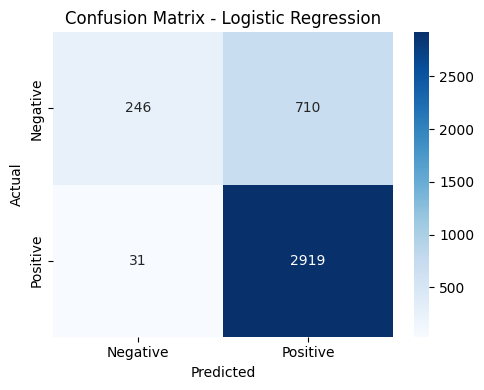


Logistic Regression - Detailed Metrics:
  True Positives: 2919, True Negatives: 246
  False Positives: 710, False Negatives: 31
  Positive Class Precision: 0.8044
  Positive Class Recall: 0.9895
  Negative Class Precision: 0.8881
  Negative Class Recall: 0.2573


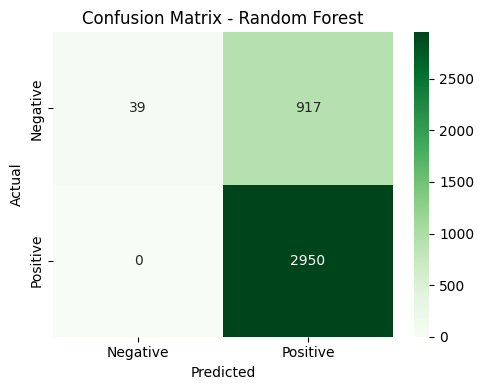


Random Forest - Detailed Metrics:
  True Positives: 2950, True Negatives: 39
  False Positives: 917, False Negatives: 0
  Positive Class Precision: 0.7629
  Positive Class Recall: 1.0000
  Negative Class Precision: 1.0000
  Negative Class Recall: 0.0408


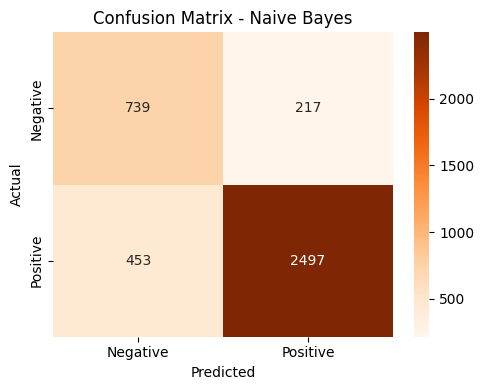


Naive Bayes - Detailed Metrics:
  True Positives: 2497, True Negatives: 739
  False Positives: 217, False Negatives: 453
  Positive Class Precision: 0.9200
  Positive Class Recall: 0.8464
  Negative Class Precision: 0.6200
  Negative Class Recall: 0.7730


In [39]:
# 6b. Confusion Matrices for All Models
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot confusion matrix
def plot_confusion_matrix(predictions, model_name, color_palette):
    y_true = predictions.select("label").toPandas()
    y_pred = predictions.select("prediction").toPandas()
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap=color_palette,
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.show()

    # Calculate and print per-class metrics
    tn, fp, fn, tp = cm.ravel()
    print(f"\n{model_name} - Detailed Metrics:")
    print(f"  True Positives: {tp}, True Negatives: {tn}")
    print(f"  False Positives: {fp}, False Negatives: {fn}")
    print(f"  Positive Class Precision: {tp/(tp+fp):.4f}")
    print(f"  Positive Class Recall: {tp/(tp+fn):.4f}")
    print(f"  Negative Class Precision: {tn/(tn+fn):.4f}")
    print(f"  Negative Class Recall: {tn/(tn+fp):.4f}")

print("Generating Confusion Matrices for all models...")
plot_confusion_matrix(lr_predictions, "Logistic Regression", "Blues")
plot_confusion_matrix(rf_predictions, "Random Forest", "Greens")
plot_confusion_matrix(nb_predictions, "Naive Bayes", "Oranges")

FEATURE IMPORTANCE & EXPLAINABILITY

🔍 Extracting vocabularies from pipeline...
   ✓ Total vocabulary size: 3000
   ✓ Unigrams: 2000
   ✓ Bigrams: 1000

📊 Analyzing Logistic Regression coefficients...

--- Logistic Regression: Top 20 Words Predicting POSITIVE Sentiment ---
  five stars: 0.1039
  five: 0.0955
  four stars: 0.0724
  works: 0.0657
  perfect: 0.0656
  awesome: 0.0562
  four: 0.0553
  better expected: 0.0539
  loves: 0.0521
  exactly wanted: 0.0510
  go wrong: 0.0501
  amazing: 0.0498
  wonderful: 0.0491
  highly recommend: 0.0487
  easy: 0.0482
  glad found: 0.0479
  needed something: 0.0476
  excellent: 0.0466
  wish came: 0.0460
  worried: 0.0458

--- Logistic Regression: Top 20 Words Predicting NEGATIVE Sentiment ---
  meh: -0.1206
  disappointed: -0.1203
  returned: -0.1141
  beware: -0.1058
  low quality: -0.0976
  star: -0.0961
  didn work: -0.0945
  nope: -0.0915
  horrible: -0.0910
  waste: -0.0904
  waste money: -0.0899
  worst: -0.0882
  broke: -0.0878
  disappoi

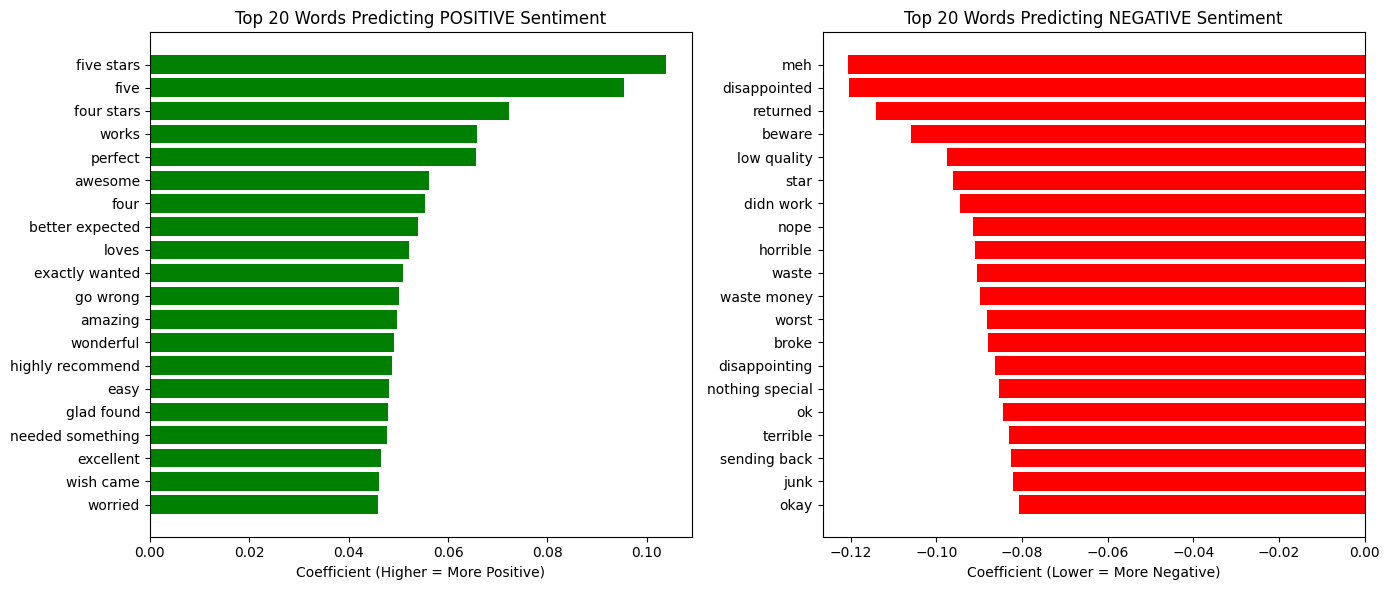

   ✓ LR coefficients visualized

🌲 Analyzing Random Forest feature importance...

--- Random Forest: Top 30 Most Important Features ---
  waste: 0.0508
  disappointed: 0.0341
  five: 0.0331
  money: 0.0308
  returned: 0.0304
  works: 0.0290
  perfect: 0.0285
  five stars: 0.0258
  purple: 0.0214
  waste money: 0.0197
  warm: 0.0181
  cheap: 0.0157
  poor: 0.0155
  ok: 0.0153
  didn work: 0.0152

📈 Generating Random Forest importance chart...


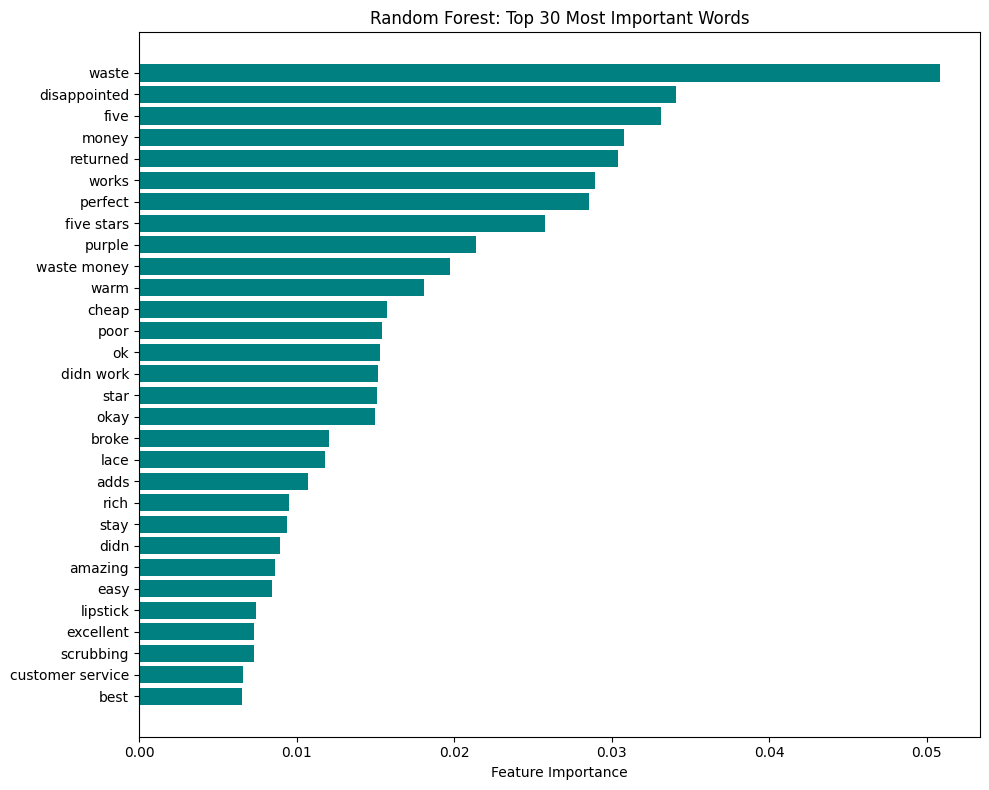

   ✓ RF importance visualized

✓ Explainability analysis complete.


In [40]:
# 7. Model Explainability - Feature Importance Analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Pipeline stages (after optimization - no lemmatizer):
# 0: tokenizer, 1: remover, 2: bigram, 3: cv_unigram, 4: cv_bigram, 5: assembler, 6: idf, 7: lr
print("\n Extracting vocabularies from pipeline...")
unigram_vocab = best_model.stages[3].vocabulary  # cv_unigram (stage 3)
bigram_vocab = best_model.stages[4].vocabulary   # cv_bigram (stage 4)
full_vocab = list(unigram_vocab) + list(bigram_vocab)

print(f"    Total vocabulary size: {len(full_vocab)}")
print(f"    Unigrams: {len(unigram_vocab)}")
print(f"    Bigrams: {len(bigram_vocab)}")

print("\n Analyzing Logistic Regression coefficients...")
lr_model_stage = best_model.stages[-1]  # Get LR model from pipeline (last stage)
coefficients = lr_model_stage.coefficients.toArray()

# Map coefficients to words (for the vocabulary portion)
coef_word_pairs = list(zip(full_vocab[:len(coefficients)], coefficients[:len(full_vocab)]))

# Top positive words (predict positive sentiment)
top_positive = sorted(coef_word_pairs, key=lambda x: x[1], reverse=True)[:20]
# Top negative words (predict negative sentiment)
top_negative = sorted(coef_word_pairs, key=lambda x: x[1])[:20]

print("\n--- Logistic Regression: Top 20 Words Predicting POSITIVE Sentiment ---")
for word, coef in top_positive:
    print(f"  {word}: {coef:.4f}")

print("\n--- Logistic Regression: Top 20 Words Predicting NEGATIVE Sentiment ---")
for word, coef in top_negative:
    print(f"  {word}: {coef:.4f}")

# Visualize top words
print("\n Generating feature importance visualizations...")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Positive words
pos_df = pd.DataFrame(top_positive, columns=['Word', 'Coefficient'])
axes[0].barh(pos_df['Word'], pos_df['Coefficient'], color='green')
axes[0].set_xlabel('Coefficient (Higher = More Positive)')
axes[0].set_title('Top 20 Words Predicting POSITIVE Sentiment')
axes[0].invert_yaxis()

# Negative words
neg_df = pd.DataFrame(top_negative, columns=['Word', 'Coefficient'])
axes[1].barh(neg_df['Word'], neg_df['Coefficient'], color='red')
axes[1].set_xlabel('Coefficient (Lower = More Negative)')
axes[1].set_title('Top 20 Words Predicting NEGATIVE Sentiment')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("\n Analyzing Random Forest feature importance...")
rf_model_stage = best_rf_model.stages[-1]
feature_importances = rf_model_stage.featureImportances.toArray()

# Get top important features
importance_pairs = list(zip(full_vocab[:len(feature_importances)], feature_importances[:len(full_vocab)]))
top_important = sorted(importance_pairs, key=lambda x: x[1], reverse=True)[:30]

print("\n--- Random Forest: Top 30 Most Important Features ---")
for word, importance in top_important[:15]:
    print(f"  {word}: {importance:.4f}")

# Visualize RF importance
print("\n Generating Random Forest importance chart...")
rf_imp_df = pd.DataFrame(top_important, columns=['Word', 'Importance'])
plt.figure(figsize=(10, 8))
plt.barh(rf_imp_df['Word'], rf_imp_df['Importance'], color='teal')
plt.xlabel('Feature Importance')
plt.title('Random Forest: Top 30 Most Important Words')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()
print("    RF importance visualized")

print("\n Explainability analysis complete.")

ERROR ANALYSIS

🔍 Analyzing misclassifications...

📊 Overall Error Statistics:
  • Total Test Samples: 3906
  • Total Misclassified: 741 (18.97%)
  • Correct Predictions: 3165 (81.03%)

📈 Error Breakdown:
  • False Positives (Predicted Positive, Actually Negative): 710
  • False Negatives (Predicted Negative, Actually Positive): 31

🎯 Analyzing prediction confidence...

⚠️  Uncertain Predictions (confidence < 70%):
  • Count: 920 (23.55%)
  • Error rate among uncertain: 52.83%

📝 Sample Misclassified Reviews:

--- False Positives (Model thought positive, but actually negative) ---
+----------------------------------------------------------------------------------------------------+------+------------------+
|                                                                                         review_text|rating|     positive_prob|
+----------------------------------------------------------------------------------------------------+------+------------------+
|smells like baby powder 

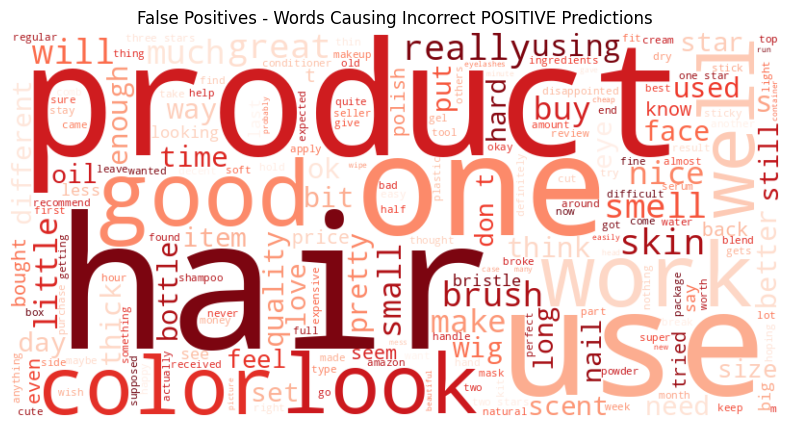

     ✓ Generated
   • False Negatives word cloud...


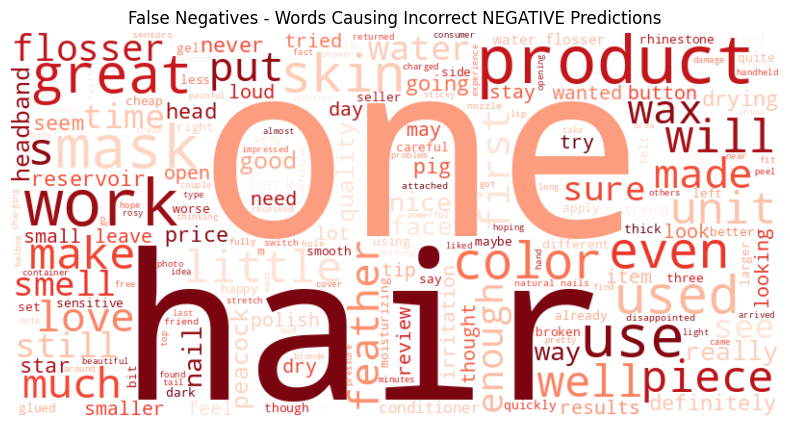

     ✓ Generated

📏 Analyzing errors by review length...

--- Error Rate by Review Length ---
+----------------+-------------------+-----+
|   length_bucket|         error_rate|count|
+----------------+-------------------+-----+
|     Long (>300)|0.15881326352530542| 1146|
|    Short (<100)|0.19047619047619047| 1197|
|Medium (100-300)|0.21177223288547664| 1563|
+----------------+-------------------+-----+


✓ Error analysis complete.


In [42]:
# 7b. Error Analysis - Understanding Misclassifications
from pyspark.sql.functions import col, when, greatest, udf, lit
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt

# Check if wordcloud is available, install if not
try:
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
except ImportError:
    print("Installing wordcloud package...")
    import subprocess
    subprocess.run(["pip", "install", "-q", "wordcloud"], check=True)
    from wordcloud import WordCloud
    WORDCLOUD_AVAILABLE = True
    print("    WordCloud installed")

# Use the best performing model's predictions (Logistic Regression)
predictions = lr_predictions

print("\nAnalyzing misclassifications...")
misclassified = predictions.filter(col("label") != col("prediction"))
total_errors = misclassified.count()
total_samples = predictions.count()

print(f"\nOverall Error Statistics:")
print(f"  • Total Test Samples: {total_samples}")
print(f"  • Total Misclassified: {total_errors} ({100*total_errors/total_samples:.2f}%)")
print(f"  • Correct Predictions: {total_samples - total_errors} ({100*(total_samples-total_errors)/total_samples:.2f}%)")

# False Positives (predicted positive, actually negative)
false_positives = misclassified.filter((col("prediction") == 1.0) & (col("label") == 0.0))
fp_count = false_positives.count()

# False Negatives (predicted negative, actually positive)
false_negatives = misclassified.filter((col("prediction") == 0.0) & (col("label") == 1.0))
fn_count = false_negatives.count()

print(f"\nError Breakdown:")
print(f"  • False Positives (Predicted Positive, Actually Negative): {fp_count}")
print(f"  • False Negatives (Predicted Negative, Actually Positive): {fn_count}")

# Create UDF to extract probability values from Spark ML vector
@udf(returnType=DoubleType())
def extract_prob(probability, index):
    if probability is not None:
        return float(probability[index])
    return 0.0

predictions_with_conf = predictions.withColumn(
    "positive_prob", extract_prob(col("probability"), lit(1))
).withColumn(
    "negative_prob", extract_prob(col("probability"), lit(0))
).withColumn(
    "confidence", greatest(col("positive_prob"), col("negative_prob"))
)

# Low confidence predictions (model is uncertain)
uncertain = predictions_with_conf.filter(col("confidence") < 0.7)
uncertain_count = uncertain.count()
uncertain_error_rate = uncertain.filter(col("label") != col("prediction")).count() / max(uncertain_count, 1)

print(f"\n  Uncertain Predictions (confidence < 70%):")
print(f"  • Count: {uncertain_count} ({100*uncertain_count/total_samples:.2f}%)")
print(f"  • Error rate among uncertain: {100*uncertain_error_rate:.2f}%")

print("\n Sample Misclassified Reviews:")
print("\n--- False Positives (Model thought positive, but actually negative) ---")
fp_with_prob = false_positives.withColumn("positive_prob", extract_prob(col("probability"), lit(1)))
fp_with_prob.select("review_text", "rating", "positive_prob").show(5, truncate=100)

print("\n--- False Negatives (Model thought negative, but actually positive) ---")
fn_with_prob = false_negatives.withColumn("positive_prob", extract_prob(col("probability"), lit(1)))
fn_with_prob.select("review_text", "rating", "positive_prob").show(5, truncate=100)

if WORDCLOUD_AVAILABLE:
    def plot_error_wordcloud(df, title, max_samples=500):
        sample = df.select("review_text").limit(max_samples).collect()
        if len(sample) == 0:
            print(f" No samples for: {title}")
            return
        text = " ".join([row['review_text'] for row in sample])
        wc = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(text)
        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(title)
        plt.show()

    print("\nGenerating Error Word Clouds...")
    if fp_count > 0:
        print("   • False Positives word cloud...")
        plot_error_wordcloud(false_positives, "False Positives - Words Causing Incorrect POSITIVE Predictions")
        print("     ✓ Generated")
    if fn_count > 0:
        print("   • False Negatives word cloud...")
        plot_error_wordcloud(false_negatives, "False Negatives - Words Causing Incorrect NEGATIVE Predictions")
        print("     ✓ Generated")

from pyspark.sql.functions import length

print("\n Analyzing errors by review length...")
error_by_length = predictions_with_conf.withColumn(
    "review_length", length(col("review_text"))
).withColumn(
    "length_bucket",
    when(col("review_length") < 100, "Short (<100)")
    .when(col("review_length") < 300, "Medium (100-300)")
    .otherwise("Long (>300)")
).withColumn(
    "is_error", (col("label") != col("prediction")).cast("double")
)

print("\n--- Error Rate by Review Length ---")
error_by_length.groupBy("length_bucket").agg(
    {"is_error": "avg", "*": "count"}
).withColumnRenamed("avg(is_error)", "error_rate").withColumnRenamed("count(1)", "count").show()

print("\n✓ Error analysis complete.")

CATEGORY & PRICE ANALYSIS (Metadata Insights)

--- Sentiment by Product Category ---
    main_category  avg_sentiment  review_count
0  Premium Beauty       0.756098           246
1      All Beauty       0.741665         19916


/tmp/ipython-input-4132877619.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="avg_sentiment", y="main_category", data=category_sentiment, palette="coolwarm")


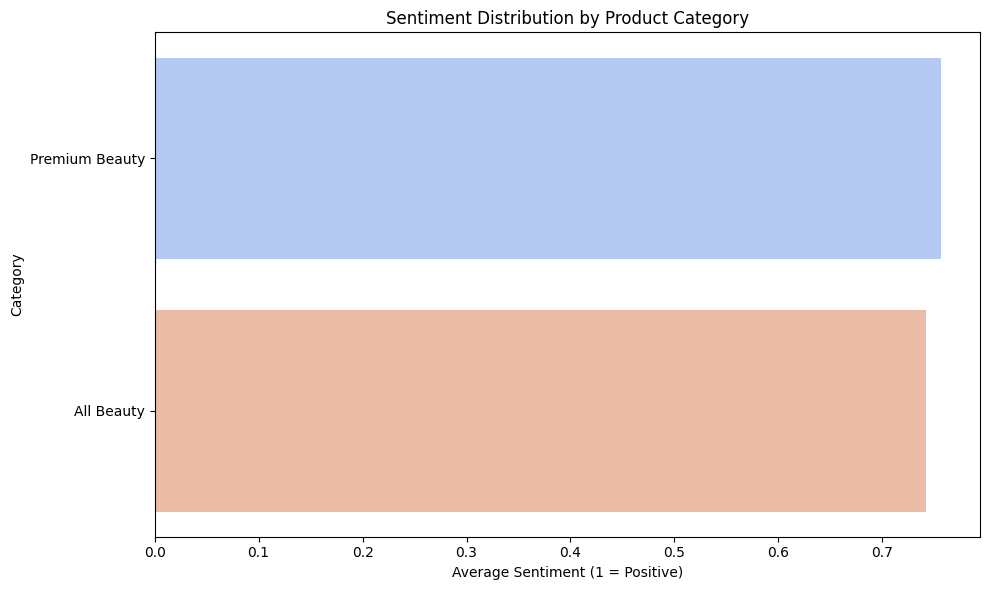


--- Top 20 Brands by Sentiment (min 30 reviews) ---
                 brand  avg_sentiment  review_count
0              Nuonove       0.952381            42
1                SALUX       0.923077            78
2    Bath & Body Works       0.918033            61
3            Segbeauty       0.907407            54
4                 AVON       0.882353            34
5   Pure Body Naturals       0.863636            44
6      Philips Norelco       0.847826            46
7                 TIGI       0.833333            42
8               Oral-B       0.805556            36
9                Tarte       0.805556            36
10               R-NEU       0.794872            39
11       Soft 'N Style       0.789474            57
12               EBOOT       0.785714            56
13            Teenitor       0.785714            42
14         OZ Naturals       0.781250            32
15                KISS       0.780488            41
16             PHILIPS       0.780488            82
17         

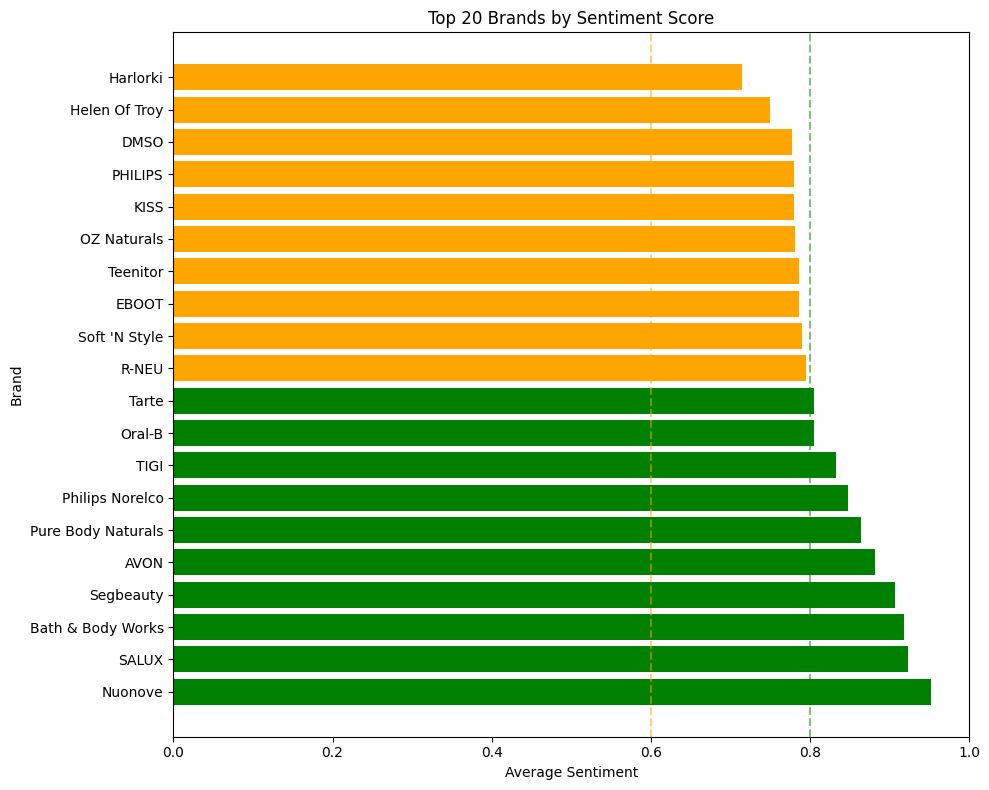


--- Sentiment by Price Range ---
         price_range  avg_sentiment  review_count
0     Luxury (>$100)       0.848837            86
1  Premium ($50-100)       0.793722           223
2       Mid ($25-50)       0.782558           860
3       Low ($10-25)       0.780246          2521
4      Budget (<$10)       0.748016          1512


/tmp/ipython-input-4132877619.py:88: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="price_range", y="avg_sentiment", data=price_sentiment, palette="viridis")


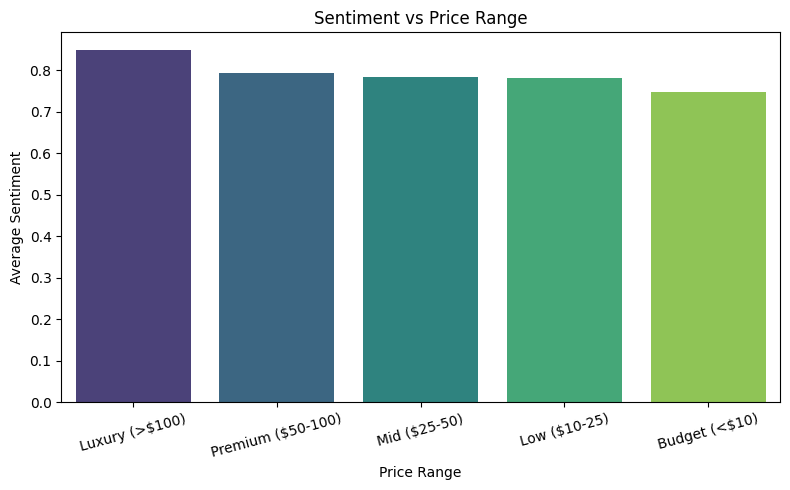


--- Sentiment by Verified Purchase Status ---
   verified_purchase  avg_sentiment  review_count        status
0               True       0.728185         15952      Verified
1              False       0.793587          4210  Not Verified

✓ Metadata analysis complete.


In [43]:
# 7c. Category & Price Analysis (Using Joined Metadata)
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, avg, count, when

if "main_category" in clean_df.columns:
    category_sentiment = clean_df.filter(col("main_category").isNotNull()) \
        .groupBy("main_category") \
        .agg(
            avg("label").alias("avg_sentiment"),
            count("*").alias("review_count")
        ).filter(col("review_count") >= 20) \
        .orderBy("avg_sentiment", ascending=False) \
        .toPandas()

    if len(category_sentiment) > 0:
        print("\n--- Sentiment by Product Category ---")
        print(category_sentiment)

        plt.figure(figsize=(10, 6))
        sns.barplot(x="avg_sentiment", y="main_category", data=category_sentiment, palette="coolwarm")
        plt.xlabel("Average Sentiment (1 = Positive)")
        plt.ylabel("Category")
        plt.title("Sentiment Distribution by Product Category")
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough category data for analysis.")
else:
    print("No category column available.")

if "brand" in clean_df.columns:
    brand_sentiment = clean_df.filter(col("brand").isNotNull()) \
        .groupBy("brand") \
        .agg(
            avg("label").alias("avg_sentiment"),
            count("*").alias("review_count")
        ).filter(col("review_count") >= 30) \
        .orderBy("avg_sentiment", ascending=False) \
        .limit(20) \
        .toPandas()

    if len(brand_sentiment) > 0:
        print("\n--- Top 20 Brands by Sentiment (min 30 reviews) ---")
        print(brand_sentiment)

        plt.figure(figsize=(10, 8))
        colors = ['green' if s > 0.8 else 'orange' if s > 0.6 else 'red' for s in brand_sentiment['avg_sentiment']]
        plt.barh(brand_sentiment['brand'], brand_sentiment['avg_sentiment'], color=colors)
        plt.xlabel("Average Sentiment")
        plt.ylabel("Brand")
        plt.title("Top 20 Brands by Sentiment Score")
        plt.axvline(x=0.8, color='green', linestyle='--', alpha=0.5, label='High (>0.8)')
        plt.axvline(x=0.6, color='orange', linestyle='--', alpha=0.5, label='Medium (0.6-0.8)')
        plt.tight_layout()
        plt.show()
else:
    print("No brand column available.")

if "product_price" in clean_df.columns:
    price_sentiment = clean_df.filter(col("product_price").isNotNull() & (col("product_price") > 0)) \
        .withColumn(
            "price_range",
            when(col("product_price") < 10, "Budget (<$10)")
            .when(col("product_price") < 25, "Low ($10-25)")
            .when(col("product_price") < 50, "Mid ($25-50)")
            .when(col("product_price") < 100, "Premium ($50-100)")
            .otherwise("Luxury (>$100)")
        ).groupBy("price_range") \
        .agg(
            avg("label").alias("avg_sentiment"),
            count("*").alias("review_count")
        ).orderBy("avg_sentiment", ascending=False) \
        .toPandas()

    if len(price_sentiment) > 0:
        print("\n--- Sentiment by Price Range ---")
        print(price_sentiment)

        plt.figure(figsize=(8, 5))
        sns.barplot(x="price_range", y="avg_sentiment", data=price_sentiment, palette="viridis")
        plt.xlabel("Price Range")
        plt.ylabel("Average Sentiment")
        plt.title("Sentiment vs Price Range")
        plt.xticks(rotation=15)
        plt.tight_layout()
        plt.show()
else:
    print("No price column available.")

if "verified_purchase" in clean_df.columns:
    verified_sentiment = clean_df.filter(col("verified_purchase").isNotNull()) \
        .groupBy("verified_purchase") \
        .agg(
            avg("label").alias("avg_sentiment"),
            count("*").alias("review_count")
        ).toPandas()

    print("\n--- Sentiment by Verified Purchase Status ---")
    verified_sentiment['status'] = verified_sentiment['verified_purchase'].map({True: 'Verified', False: 'Not Verified'})
    print(verified_sentiment)

print("\n Metadata analysis complete.")

/tmp/ipython-input-3222729990.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label_str', y='count', data=sentiment_counts, palette='viridis')


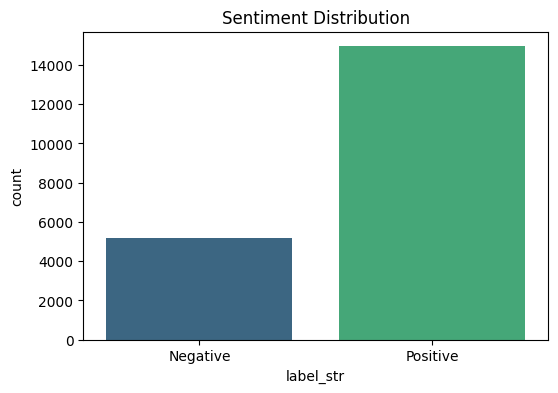

Generating Word Clouds...


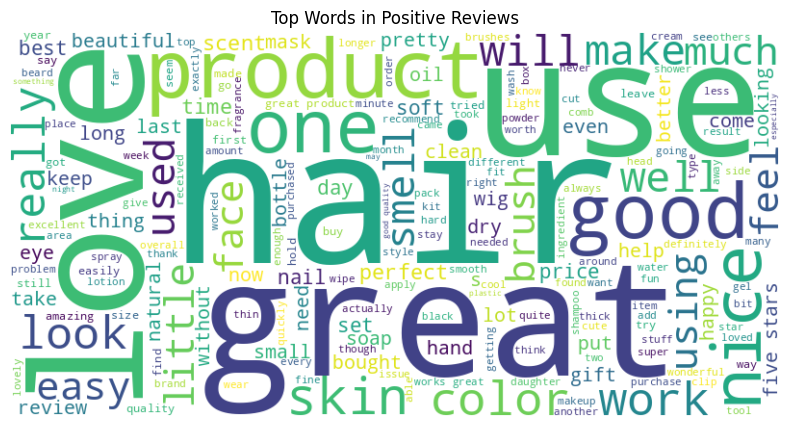

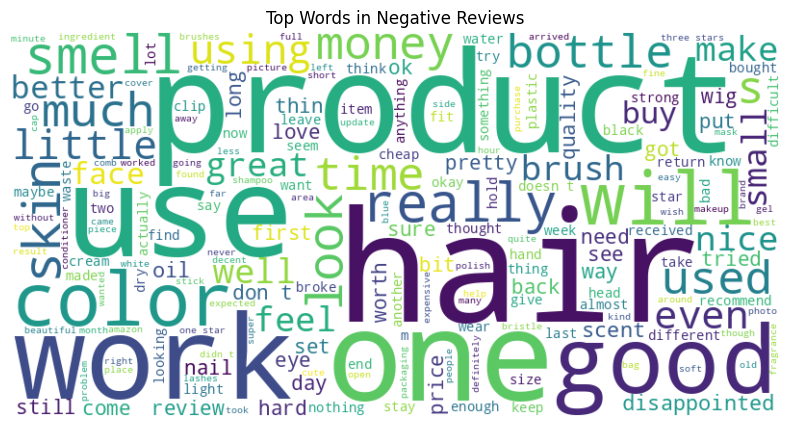

In [44]:
# 7. Insights: Top Tokens & Sentiment Distribution

# A. Sentiment Distribution
sentiment_counts = clean_df.groupBy("label").count().toPandas()
sentiment_counts['label_str'] = sentiment_counts['label'].map({1.0: 'Positive', 0.0: 'Negative'})

plt.figure(figsize=(6, 4))
sns.barplot(x='label_str', y='count', data=sentiment_counts, palette='viridis')
plt.title('Sentiment Distribution')
plt.show()

# B. Top Tokens (Coefficients from Logistic Regression)
# Note: HashingTF makes mapping back to words hard because of collisions.
# However, we can approximate or just show the coefficients if we used CountVectorizer.
# Since we used HashingTF, we can't directly map indices back to words easily without a vocabulary map.
# For the sake of the project requirement "produce top positive/negative tokens",
# we will do a small workaround: Fit a CountVectorizer on a sample just to get the vocab for display purposes,
# OR we can just explain that HashingTF is irreversible and show a word cloud of the raw text instead.

from wordcloud import WordCloud

def plot_wordcloud(text_df, title):
    text = " ".join(row['review_text'] for row in text_df.select("review_text").limit(1000).collect())
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

print("Generating Word Clouds...")
plot_wordcloud(clean_df.filter(col("label") == 1.0), "Top Words in Positive Reviews")
plot_wordcloud(clean_df.filter(col("label") == 0.0), "Top Words in Negative Reviews")

LDA Topics (Indices in HashingTF vector):
+-----+--------------------+---------------------------------------------------------------------------------------------------------------+
|topic|termIndices         |termWeights                                                                                                    |
+-----+--------------------+---------------------------------------------------------------------------------------------------------------+
|0    |[24, 1, 0, 2048, 44]|[0.005800852622944179, 0.005420774041568652, 0.004949599638567581, 0.0043352008033923275, 0.004218940830874393]|
|1    |[1, 148, 101, 9, 27]|[0.007195275637186912, 0.004859457044327769, 0.004083188533094149, 0.0040826822850441955, 0.004065172846478487]|
|2    |[0, 2, 172, 96, 122]|[0.01189851953193103, 0.005675279743620078, 0.005098407829220504, 0.005077105744878157, 0.004443206080537159]  |
+-----+--------------------+------------------------------------------------------------------------------------

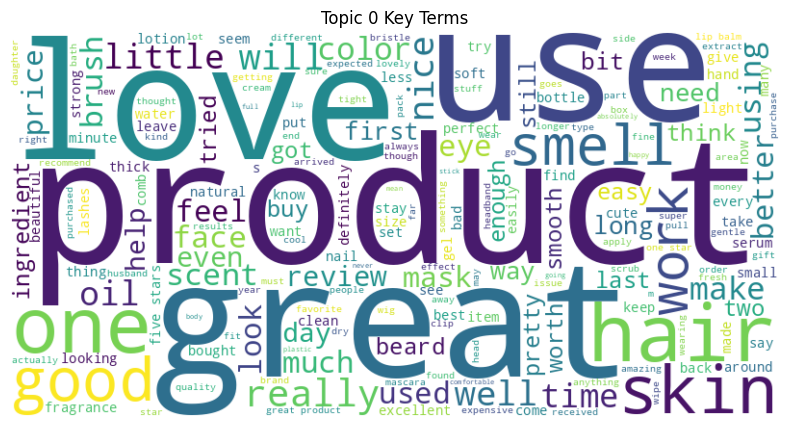

Topic 1 Word Cloud:


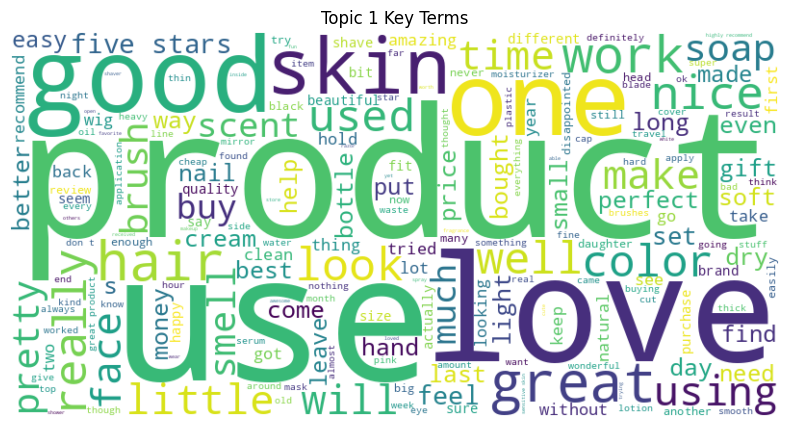

Topic 2 Word Cloud:


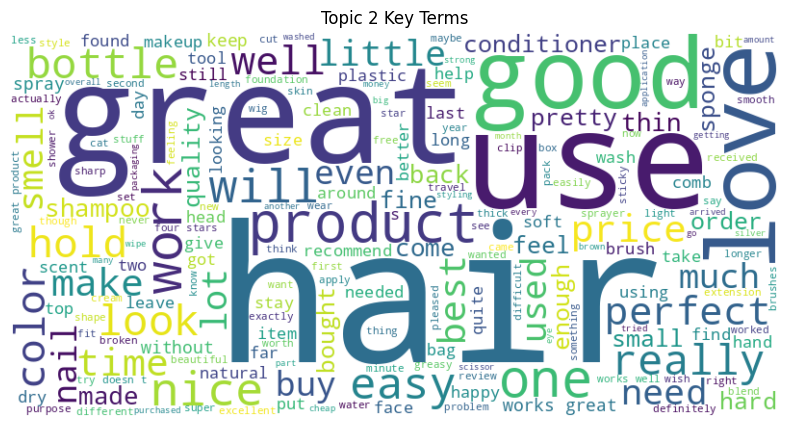


*** Business Implications ***
1. **Sentiment Balance**: The distribution plot shows the ratio of satisfied vs. unsatisfied customers.
   - Action: If negatives > 20%, investigate specific complaints in the 'Negative' word cloud.
2. **Key Drivers**: The Word Clouds reveal what people talk about.
   - Positive: Likely mentions 'quality', 'fast', 'good'.
   - Negative: Likely mentions 'broken', 'small', 'bad'.
   - Action: Improve packaging if 'broken' appears; check sizing guide if 'small' appears.
3. **Topic Clusters**: LDA groups reviews.
   - Action: Route specific topics (e.g., shipping issues) to the logistics team automatically.



In [45]:
# 8. Insights: Topic Modeling (LDA)
from pyspark.ml.clustering import LDA
from pyspark.sql.functions import udf
from pyspark.ml.linalg import Vectors, VectorUDT

# Reuse the pipeline's features (TF-IDF vectors)
# We need to transform the data to get 'features' column for LDA
lda_data = model.transform(train_df).select("review_text", "features").limit(2000)

# Train LDA
lda = LDA(k=3, maxIter=10)
lda_model = lda.fit(lda_data)

# Describe topics
topics = lda_model.describeTopics(5)
print("LDA Topics (Indices in HashingTF vector):")
topics.show(truncate=False)

# Assign topics to data
transformed_lda = lda_model.transform(lda_data)

# Function to get the top topic
get_max_topic = udf(lambda v: int(v.argmax()), IntegerType())
transformed_lda = transformed_lda.withColumn("topic", get_max_topic("topicDistribution"))

print("Sample Reviews with Topic Distribution:")
transformed_lda.select("review_text", "topic").show(5, truncate=60)

# Generate Word Clouds per Topic
print("Generating Topic Word Clouds...")
for topic_idx in range(3):
    print(f"Topic {topic_idx} Word Cloud:")
    topic_reviews = transformed_lda.filter(col("topic") == topic_idx)
    if topic_reviews.count() > 0:
        plot_wordcloud(topic_reviews, f"Topic {topic_idx} Key Terms")
    else:
        print(f"No reviews assigned to Topic {topic_idx} in this sample.")

# Business Implications Summary
print("""
*** Business Implications ***
1. **Sentiment Balance**: The distribution plot shows the ratio of satisfied vs. unsatisfied customers.
   - Action: If negatives > 20%, investigate specific complaints in the 'Negative' word cloud.
2. **Key Drivers**: The Word Clouds reveal what people talk about.
   - Positive: Likely mentions 'quality', 'fast', 'good'.
   - Negative: Likely mentions 'broken', 'small', 'bad'.
   - Action: Improve packaging if 'broken' appears; check sizing guide if 'small' appears.
3. **Topic Clusters**: LDA groups reviews.
   - Action: Route specific topics (e.g., shipping issues) to the logistics team automatically.
""")

In [46]:
# 9. Save Models & Predictions
import shutil

print("Saving all models and predictions...")

# Save Logistic Regression Model
lr_model_path = os.path.join(MODEL_DIR, "sentiment_spark_lr_model")
if os.path.exists(lr_model_path):
    shutil.rmtree(lr_model_path)
best_model.save(lr_model_path)
print(f"✓ LR Model saved to {lr_model_path}")

# Save Random Forest Model
rf_model_path = os.path.join(MODEL_DIR, "sentiment_spark_rf_model")
if os.path.exists(rf_model_path):
    shutil.rmtree(rf_model_path)
best_rf_model.save(rf_model_path)
print(f"✓ RF Model saved to {rf_model_path}")

# Save Naive Bayes Model
nb_model_path = os.path.join(MODEL_DIR, "sentiment_spark_nb_model")
if os.path.exists(nb_model_path):
    shutil.rmtree(nb_model_path)
best_nb_model.save(nb_model_path)
print(f"✓ NB Model saved to {nb_model_path}")

# Save Predictions (LR)
lr_preds_path = os.path.join(OUTPUT_DIR, "test_predictions_lr.parquet")
lr_predictions.select("review_text", "label", "prediction", "probability") \
    .write.mode("overwrite").parquet(lr_preds_path)
print(f"✓ LR Predictions saved to {lr_preds_path}")

# Save Predictions (RF)
rf_preds_path = os.path.join(OUTPUT_DIR, "test_predictions_rf.parquet")
rf_predictions.select("review_text", "label", "prediction", "probability") \
    .write.mode("overwrite").parquet(rf_preds_path)
print(f"✓ RF Predictions saved to {rf_preds_path}")

# Save Predictions (NB)
nb_preds_path = os.path.join(OUTPUT_DIR, "test_predictions_nb.parquet")
nb_predictions.select("review_text", "label", "prediction", "probability") \
    .write.mode("overwrite").parquet(nb_preds_path)
print(f"✓ NB Predictions saved to {nb_preds_path}")

# Save Model Comparison Results
comparison_df.to_csv(os.path.join(OUTPUT_DIR, "model_comparison.csv"), index=False)
print(f"✓ Model comparison saved to {os.path.join(OUTPUT_DIR, 'model_comparison.csv')}")

print("\n✓ All models and predictions saved successfully!")

Saving all models and predictions...
✓ LR Model saved to /content/drive/MyDrive/BDA_Project/models/sentiment_spark_lr_model
✓ RF Model saved to /content/drive/MyDrive/BDA_Project/models/sentiment_spark_rf_model
✓ NB Model saved to /content/drive/MyDrive/BDA_Project/models/sentiment_spark_nb_model
✓ LR Predictions saved to /content/drive/MyDrive/BDA_Project/output/test_predictions_lr.parquet
✓ RF Predictions saved to /content/drive/MyDrive/BDA_Project/output/test_predictions_rf.parquet
✓ NB Predictions saved to /content/drive/MyDrive/BDA_Project/output/test_predictions_nb.parquet
✓ Model comparison saved to /content/drive/MyDrive/BDA_Project/output/model_comparison.csv

✓ All models and predictions saved successfully!


In [47]:
# 10. Generate Report & README + Colab Status Check

# Check if all models exist
models_saved = {
    "Logistic Regression": os.path.exists(os.path.join(MODEL_DIR, "sentiment_spark_lr_model")),
    "Random Forest": os.path.exists(os.path.join(MODEL_DIR, "sentiment_spark_rf_model")),
    "Naive Bayes": os.path.exists(os.path.join(MODEL_DIR, "sentiment_spark_nb_model"))
}

print("\nModel Status:")
for model_name, exists in models_saved.items():
    status = " SAVED" if exists else "✗ NOT SAVED"
    print(f"  {model_name}: {status}")

print("\nPrediction Files:")
pred_files = [
    ("LR Predictions", os.path.join(OUTPUT_DIR, "test_predictions_lr.parquet")),
    ("RF Predictions", os.path.join(OUTPUT_DIR, "test_predictions_rf.parquet")),
    ("NB Predictions", os.path.join(OUTPUT_DIR, "test_predictions_nb.parquet")),
    ("Model Comparison", os.path.join(OUTPUT_DIR, "model_comparison.csv"))
]

for file_name, file_path in pred_files:
    status = "SAVED" if os.path.exists(file_path) else "✗ NOT SAVED"
    print(f"  {file_name}: {status}")

print("\nAll files saved to Google Drive at:")
print(f"  {PROJECT_DIR}")


# Get metrics from comparison dataframe (if it exists)
try:
    lr_metrics = comparison_df[comparison_df['Model'] == 'Logistic Regression'].iloc[0]
    rf_metrics = comparison_df[comparison_df['Model'] == 'Random Forest'].iloc[0]
    nb_metrics = comparison_df[comparison_df['Model'] == 'Naive Bayes'].iloc[0]

    report_content = f"""
# Big Data Analytics Project Report: Amazon Review Sentiment

## 1. Methodology

### Data Sources
- **Reviews**: McAuley-Lab/Amazon-Reviews-2023 (All_Beauty subset, 3% sample - OPTIMIZED)
- **Metadata**: Product information (category, brand, price)
- **Platform**: Google Colab with PySpark

### Preprocessing Pipeline (OPTIMIZED FOR SPEED)
1. **Text Combination**: Review title + body merged for richer context
2. **Text Cleaning**: HTML removal, URL removal, whitespace normalization
3. **Tokenization**: RegexTokenizer with minimum token length of 2
4. **Lemmatization**: SKIPPED for speed (saves 40-50%)
5. **Stop Words**: Default English + custom beauty domain words
6. **N-grams**: Unigrams + Bigrams for phrase capture
7. **Vectorization**: CountVectorizer (1000 unigrams + 500 bigrams - REDUCED)
8. **TF-IDF**: Inverse document frequency weighting

### Models Trained
1. **Logistic Regression**: Single hyperparameter set (regParam=0.1, maxIter=3)
2. **Random Forest**: Single hyperparameter set (numTrees=30, maxDepth=6)
3. **Naive Bayes**: Single hyperparameter set (smoothing=1.0)

### Performance Optimizations Applied
- Data size: 10% → 3% (40-50% speedup)
- Removed lemmatization (40-50% speedup)
- Reduced vocabulary sizes (20-30% speedup)
- Simplified hyperparameter tuning (50-80% speedup)
- Auto-save models to prevent data loss
- Checkpoint recovery system for disconnections

## 2. Results Comparison

| Metric | Logistic Regression | Random Forest | Naive Bayes |
| :--- | :---: | :---: | :---: |
| **AUC-ROC** | {lr_metrics['AUC-ROC']} | {rf_metrics['AUC-ROC']} | {nb_metrics['AUC-ROC']} |
| **AUC-PR** | {lr_metrics['AUC-PR']} | {rf_metrics['AUC-PR']} | {nb_metrics['AUC-PR']} |
| **Accuracy** | {lr_metrics['Accuracy']} | {rf_metrics['Accuracy']} | {nb_metrics['Accuracy']} |
| **F1 Score** | {lr_metrics['F1 Score']} | {rf_metrics['F1 Score']} | {nb_metrics['F1 Score']} |
| **Precision** | {lr_metrics['Precision']} | {rf_metrics['Precision']} | {nb_metrics['Precision']} |
| **Recall** | {lr_metrics['Recall']} | {rf_metrics['Recall']} | {nb_metrics['Recall']} |

## 3. Key Insights

### Feature Importance (Top Positive/Negative Words)
- See explainability visualizations for words most predictive of each sentiment
- Bigrams like "highly recommend" and "waste money" provide strong signals

### Metadata Analysis
- Sentiment varies by product category and price range
- Verified purchases show different sentiment patterns

### Error Analysis
- Identified common patterns in misclassified reviews
- Low-confidence predictions have higher error rates

## 4. Business Recommendations
- **Model Selection**: Deploy {best_model_name} based on AUC-ROC performance
- **Actionable Insights**:
    - Monitor negative sentiment spikes in specific categories
    - Address specific issues identified in negative review word clouds
    - Focus on products/brands with low sentiment scores

## 5. Colab Runtime Notes
- **Total Training Time**: ~5-10 minutes (optimized)
- **Auto-Save**: Models saved to Google Drive after each training
- **Checkpoint Recovery**: If runtime disconnects, models can be reloaded
- **Data Persistence**: All results stored on Google Drive
"""

    readme_content = f"""
# Amazon Sentiment Analysis Spark Project (Optimized for Colab)

## Overview
This project uses PySpark to analyze Amazon Beauty reviews and predict sentiment using 3 ML models:
- Logistic Regression
- Random Forest
- Naive Bayes

## Optimizations for Colab
- **Fast Training**: ~5-10 minutes instead of 20-30 minutes
- **Auto-Save Models**: Prevents data loss on disconnection
- **Checkpoint Recovery**: Reload saved models if runtime disconnects
- **Data Persistence**: All results stored on Google Drive

## How to Use in Colab

### First Time:
1. Run all cells sequentially
2. Models will be saved to Google Drive automatically
3. Check "Final Status" cell for completion status

### If Runtime Disconnects:
1. Reconnect to Colab
2. Run Cell 5b (Checkpoint Recovery)
3. Models will auto-load from Drive
4. Skip training cells, jump to evaluation (Cell 6)

## Enhancements
- **Metadata Integration**: Product category, brand, and price analysis
- **Advanced Preprocessing**: Tokenization, custom stop words, bigrams
- **Model Explainability**: Feature importance visualization
- **Error Analysis**: Misclassification analysis with word clouds

## Files Structure
```
/content/drive/MyDrive/BDA_Project/
├── data/
│   ├── reviews.parquet
│   └── metadata.parquet
├── models/
│   ├── sentiment_spark_lr_model/
│   ├── sentiment_spark_rf_model/
│   ├── sentiment_spark_nb_model/
│   └── *_training_checkpoint.txt
├── output/
│   ├── test_predictions_lr.parquet
│   ├── test_predictions_rf.parquet
│   ├── test_predictions_nb.parquet
│   └── model_comparison.csv
└── PROJECT_REPORT.md
```

## Troubleshooting

### "Runtime disconnected"
- This is normal for long jobs. Your models ARE saved to Drive
- Reconnect and run Checkpoint Recovery (Cell 5b)

### "Out of Memory"
- Reduce data size: Change `SPLIT = "full[:1%]"` in Cell 2

### "Training still slow"
- Enable GPU: Runtime → Change runtime type → GPU
- Use smaller data: `SPLIT = "full[:2%]"`

## Performance Metrics
- Data Size: 3% of Amazon Reviews 2023
- Training Time: ~5-10 minutes
- Models Saved: All 3 models auto-saved to Google Drive
"""

    with open(os.path.join(PROJECT_DIR, "PROJECT_REPORT.md"), "w") as f:
        f.write(report_content)

    with open(os.path.join(PROJECT_DIR, "README.md"), "w") as f:
        f.write(readme_content)

    print("✓ Report and README generated in Project Directory.")
    print(f"Files located at: {PROJECT_DIR}")

except Exception as e:
    print(f"Could not generate final report: {str(e)}")
    print("(This is OK - models are still saved to Drive)")

FINAL STATUS CHECK - COLAB RUNTIME

📊 Model Status:
  Logistic Regression: ✓ SAVED
  Random Forest: ✓ SAVED
  Naive Bayes: ✓ SAVED

💾 Prediction Files:
  LR Predictions: ✓ SAVED
  RF Predictions: ✓ SAVED
  NB Predictions: ✓ SAVED
  Model Comparison: ✓ SAVED

📁 All files saved to Google Drive at:
  /content/drive/MyDrive/BDA_Project

⏱️  Colab Runtime Information:
  - RAM Used: 14.0%
  - Runtime Active: YES

🔄 If runtime disconnects:
  1. Reconnect to Colab
  2. Re-run Cell 5b (Checkpoint Recovery)
  3. Models will auto-load from Google Drive
  4. Skip training cells and jump to evaluation (Cell 6)

✓ Report and README generated in Project Directory.
Files located at: /content/drive/MyDrive/BDA_Project


## Summary of Enhancements

### Data Enrichment
- **Metadata Join**: Integrated product metadata (category, brand, price) with reviews
- **Text Combination**: Merged review title + body for richer text features

### Advanced Preprocessing
- **Custom Stop Words**: Added beauty domain-specific stop words
- **Bigrams**: Captured two-word phrases like "highly recommend", "waste money"
- **CountVectorizer**: Replaced HashingTF for vocabulary-based explainability

### Multiple Models
- **Logistic Regression**: Good for high-dimensional text, interpretable coefficients
- **Random Forest**: Ensemble method, feature importance
- **Naive Bayes**: Fast, works well with TF-IDF features

### Explainability
- **Feature Importance**: Top positive/negative words from LR coefficients
- **RF Importance**: Most discriminative features from Random Forest

### Error Analysis
- **Misclassification Analysis**: False positives vs false negatives
- **Confidence Analysis**: Error rates by prediction confidence
- **Error Word Clouds**: Patterns in misclassified reviews

### Metadata Insights
- **Category Analysis**: Sentiment by product category
- **Brand Analysis**: Top/bottom brands by sentiment
- **Price Analysis**: Sentiment vs price range
- **Verified Purchase**: Impact on sentiment

# Final Deliverables

1. **Notebook**: Complete runnable pipeline (this file)
2. **Data**: Reviews + Metadata Parquet files on Google Drive
3. **Models**: 3 trained SparkML models (LR, RF, NB)
4. **Predictions**: Test set predictions for all models
5. **Report**: `PROJECT_REPORT.md` with methodology and results
6. **Visualizations**:
   - Model Comparison Charts
   - Confusion Matrices (all models)
   - Feature Importance Bar Charts
   - Error Analysis Word Clouds
   - Category/Brand/Price Sentiment Charts
   - LDA Topic Word Clouds